# EE514 Assignment - Aidan Smyth 13452192


## Run Instructions
To run this notebook, click on this cell annd select "Cell -> Run All Below". Run time takes approximately 5 minutes on my basic laptop.

## Introduction

The primary goal of this project is to create a supervised classification process that effectively classifies emails from the Enron email dataset as spam or non-spam. The full dataset is available at: http://www.aueb.gr/users/ion/data/enron-spam/. The emails have been pre-classified as spam or non-spam.

This is an example of a binary classification problem, where emails are asssigned feature vectors depending on the occurences of words, and target variabels {1,0} depending on whether the email is classified as spam or not spam (ham). The objective is to use the examples from training set to design up with a function that can map a feature representation of an email to the correct target variable.





## Preprocessing

The first stage in the pipeline is to spilt the test and training data: 70% for the training data and the remainder for the validation and test sets. Testing is an essential aspect of machine learning as the classifiers are trained to estimate for the unknown test samples. As the data set is large hold out validation is sufficient, and there is no need to consider cross-validation.

If there was no data set split then there would be zero measured error, as overfitting would take place.The classifier would effectively memorize the whole data set. This is of no benefit for developing a supervised learning classifier, there must be an unseen test data set to measure the classifier's accuracy. There is a trade-off to be made when splitting the data set. It is important to keep as much data as possible but still keep enough to have low variance estimate of out-of-sample error (OOS).

The goal when splitting data is to keep as much data for training but still have enough to have low variance estimate of OOS. The entire data set is shuffled and then split, with 70% of the data allocated to the training set. The resulting data sets are stored in seperate pandas data frames. Statistics are collected and recorded on both sets. 

The training data (70%) is split in a 5/2 ratio, with the lower ratio being assigned as a hold out validation data set. Alternatively cross validation may bu used, but for the large data set is computationally expensive. Thus, a hold out validation set is used.

The validtion set is used to estimate OOS error and select hyperparameters. The test set is used at the end on the selected classification model for evaluation purposes.


### Loading Data Set

The first step is to import the key Python libraries that will be used throughout the program. Note that other libraries are imported as neeeded throughout the code.

In [96]:
%pylab inline
import numpy as np;
import pandas as pd; 
import os;

Populating the interactive namespace from numpy and matplotlib


C:\Users\Public\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mod', 'cm', 'text', 'shuffle', 'f', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


The OS library *walk* fucntion can traverse directories efficiently, extracting details on subdirectories and files

In [97]:
# [1]
dirpath = 'C:/Users/Public/Anaconda3/EE514/Assignment/enron/pre/';

for directories, subdirs,files in os.walk(dirpath):
    print(directories, subdirs, len(files)); 

C:/Users/Public/Anaconda3/EE514/Assignment/enron/pre/ ['enron1', 'enron2', 'enron3', 'enron4', 'enron5', 'enron6'] 0
C:/Users/Public/Anaconda3/EE514/Assignment/enron/pre/enron1 ['ham', 'spam'] 1
C:/Users/Public/Anaconda3/EE514/Assignment/enron/pre/enron1\ham [] 3672
C:/Users/Public/Anaconda3/EE514/Assignment/enron/pre/enron1\spam [] 1500
C:/Users/Public/Anaconda3/EE514/Assignment/enron/pre/enron2 ['ham', 'spam'] 1
C:/Users/Public/Anaconda3/EE514/Assignment/enron/pre/enron2\ham [] 4361
C:/Users/Public/Anaconda3/EE514/Assignment/enron/pre/enron2\spam [] 1496
C:/Users/Public/Anaconda3/EE514/Assignment/enron/pre/enron3 ['ham', 'spam'] 1
C:/Users/Public/Anaconda3/EE514/Assignment/enron/pre/enron3\ham [] 4012
C:/Users/Public/Anaconda3/EE514/Assignment/enron/pre/enron3\spam [] 1500
C:/Users/Public/Anaconda3/EE514/Assignment/enron/pre/enron4 ['ham', 'spam'] 1
C:/Users/Public/Anaconda3/EE514/Assignment/enron/pre/enron4\ham [] 1500
C:/Users/Public/Anaconda3/EE514/Assignment/enron/pre/enron4\spam



The email files are read as strings and appended to list objects, depending on whether they belong to the ham or spam subdirectories. The lists are then converted to Pandas DataFrame objects, with seperate taget variables defined as *Spam* and the string text defined as *Email*.

The Spam target value is a binary description of the Boolean Spam attribute of the data.

The two DataFrames are concatenated to create a combined DataFrame that contains string features and binary target variables.

In [4]:
ham_list = [];
spam_list = [];

# from [2]
for directories, subdirs,files in os.walk(dirpath):
  
    if (os.path.split(directories)[1]  == 'ham'):
        for fle in files:
            with open(os.path.join(directories, fle),encoding="latin-1") as f:
                text = f.read();
                ham_list.append(text);
                
                
    if (os.path.split(directories)[1]  == 'spam'):
        for fle in files:
            with open(os.path.join(directories, fle),encoding="latin-1") as f:
                text = f.read();
                spam_list.append(text);

spam_ones = [1] * len(spam_list);
ham_zeros = [0] * len(ham_list);

# appends spam binary class to text files
dfSpam = pd.DataFrame(
    {'Spam': spam_ones,
    'Email': spam_list
    })

dfHam = pd.DataFrame(
    {'Spam': ham_zeros,
    'Email': ham_list
    })

dfTotal = pd.concat([dfHam, dfSpam])


It is important that the DataFrame is randomized as part of the pre-processing to avoid biasing the classifier. The sklearn *shuffle* function provides this capability, as well as a *random_state* parameter for reproductibility of results. The indexes of the shuffled data are reset.


From quick observation of the emails and noting that the CountVectorizer used in the Feature Extraction section does not remove numbers, it is desireable to remove or replace the number occurences in the strings. By replacing the numbers with stop words that will be removed during feature extraction, the structural size of the emails are maintained. The word "and" will be removed as a stop word in the next section, so all numerical instances are replaced with this word.

In [5]:
from sklearn.utils import shuffle

dfTotal = shuffle(dfTotal,random_state=0)
dfTotal = dfTotal.reset_index(drop=True);
dfTotal = dfTotal.replace('\d+', 'and', regex=True)
dfTotal.head(10)

,Email,Spam
0,"Subject: gmt . inc .\ntom ,\nplease create a s...",0
1,Subject: what car will you buy bait - excelled...,1
2,Subject: ferc orders on ca and rto west\n- - -...,0
3,Subject: reviews\nheather will be calling each...,0
4,Subject: sshs . . get low cost software cds or...,1
5,Subject: our pro - forma invoice attached\nund...,1
6,Subject: top - quality prescripiton drvgs\nred...,1
7,Subject: re : paliourg home info you requested...,1
8,Subject: start date : and / and / and ; hourah...,0
9,Subject: award notification ( file for claim )...,1


### Training Test Split

The sklearn cross validation library provides an easy to use training test split. A second split is used to sperate training and validation data. The feature vectors and target variables are stored in seperate objects of similar dimensions. The test set is seen again until the classifier has been trained using the test set.

In [6]:
# split 70% train, 30% test
from sklearn.cross_validation import train_test_split
email_tv,email_test,spam_tv,spam_test = train_test_split(dfTotal.Email,dfTotal.Spam,test_size=0.3,random_state=0)

# 70% * 1/3.5 = 20%
email_train,email_val,spam_train,spam_val = train_test_split(email_tv,spam_tv,test_size=(1/3.5),random_state=0)

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Pre-processing Data Set Statistics
The statistics recorded include:
- the shape of the data sets
- total number of spam and non-spam emails
- total number of features and target variable in each set

The Exploratory Analysis section describes deeper analysis of the data sets, the statistics in this section are used as confirmation that pre-processing has correctly split the data.

In [7]:
# Set features and targets should match
print(email_train.shape)
print(spam_train.shape)
print(email_val.shape)
print(spam_val.shape)
print(email_test.shape)
print(spam_test.shape)

print("There are "+ str(len(dfTotal))+" total files.");
print("There are "+str(len(email_train))+" training set files (50%).");
print("There are "+str(len(email_val))+" validation set files (20%).");
print("There are "+str(len(email_test))+ " test set files (30%).");

(16857,)
(16857,)
(6744,)
(6744,)
(10115,)
(10115,)
There are 33716 total files.
There are 16857 training set files (50%).
There are 6744 validation set files (20%).
There are 10115 test set files (30%).


In [8]:
totalSpam = dfTotal.loc[dfTotal.Spam == 1]
totalHam = dfTotal.loc[dfTotal.Spam == 0]

trainingSpam = email_train.loc[spam_train.values == 1]
trainingHam = email_train.loc[spam_train.values == 0]

valSpam = email_val.loc[spam_val.values == 1]
valHam = email_val.loc[spam_val.values == 0]

testSpam = email_test.loc[spam_test.values == 1]
testHam = email_test.loc[spam_test.values == 0]

print("There are "+ str(len(totalSpam))+" total spam emails.");
print("There are "+ str(len(totalHam))+" total ham emails.");
print("There are "+ str(len(trainingSpam))+" training spam emails.");
print("There are "+ str(len(trainingHam))+" training ham emails.");
print("There are "+ str(len(valSpam))+" validation spam emails.");
print("There are "+ str(len(valHam))+" validation ham emails.");
print("There are "+ str(len(testSpam))+" test spam emails.");
print("There are "+ str(len(testHam))+" test ham emails.");


There are 17171 total spam emails.
There are 16545 total ham emails.
There are 8520 training spam emails.
There are 8337 training ham emails.
There are 3467 validation spam emails.
There are 3277 validation ham emails.
There are 5184 test spam emails.
There are 4931 test ham emails.






The Bag of Words model for both spam and ham emails can be from the pre-processed data and stored as seperate DataFrames for ease of access.

## Feature Extraction
The second stage of the pipeline is to extract the features that will be used in the email classifier. The features will be text-based, which is not as intuitive to represent as numbers. Bag of Words is the easiest way to represent the words as binary features in the emails.


### Bag of Words
Bag of Words is a method of feature extraction from text data. It is a representation of the presence of known words in a given vocabulary. Feature words are tokenized and represented as vectors of word occurences throughout a string or list of strings.

The features included in the bag of words models affect the performance of the final classifier. There are many possibilities to reduce the features and dimensionality, providing a better more generalized solution. These methods include:

- Remove stop words
- Remove infrequent and highly frequent word occurences
- TF-IDF Encoding
- N-grams
- Stemming

A combination of some of these feature extraction techniques are chosen that will best optimize the classification accuracy.


#### Stop words

Stop words are a list of words that are so common that they are usually filtered out preprocessing. Some examples include "he", "she", "they" and "our". This decision can greatly affect the classifier training, and is tested with or without stop words. Note that n-grams require stop words to remain in place, so it is not always a given to remove stop words. The count vectorizer stop_words parameter offers three options for stop words:

- Remove a pre-defined list of English stop words ('english').
- Remove a user-defined list of stop words.
- Remove no stop words ('None'), the default option.

#### Infrequent and Frequent Words

Words that occur infrequently in the data sets are of limited benefit to the classifier, as are words that occur in every nearly every document (similar to stop words). The count vectorizer offers a method to remove infrequenct or highly frequent words. The frequency can be specified as a float (percentage occurence in all documents) or an integer (number of occurences over all documents). It is good practice for min_df to be an integer number, and max_df to be a float.

#### TF-IDF

No matter how low the max_df frequency is configured, there will always be high frequency words that offer little benefit to the supervised learning classifier. TF-IDF is a method of attributing a high value for a given term if it appears often in a particular document and less frequently everywhere else. This describes Term Frequency-Inverse Document Frequency (TF-IDF). [3] TF-IDF basically scales down the impact of words that occur very frequently in a given document and are empirically less informative than features that occur in a small fraction of the training set. The formula for TF-IDF encoding is explained in [4].

The count vectorizer can be copied and transformed to TF-IDF encoding using the transform(X, copy=True) method in sklearn.feature_extraction.text.TfidfTransformer.


#### N-grams

N-grams take N-word pairs in a Bag of Words representation. The use of phrases rather than indivual words with no context in theory should produce more relevant results. However, the use of N-grams would mean that other techniques such as stop words usage and stemming would no longer be suitable. A decision must be made in the design of the model as to which feature extraction methods are more appropriate. For the large Enron email data set, stop word removal should produce more efficient results compared to the use of N-grams, whcih may be computationally costly.



#### CountVectorizer

The sklearn.feature_extraction.text is useful for creating a Bag of Words representation of the ham or spam training sets. CountVectorizer converts a collection of text documents to a matrix of token counts, producing a sparse representation of the counts using scipy.sparse.csr_matrix.

The CountVectorizer is transformed into a vocabulary of words using the *fit()* function, followed by the *transform()* function to transform the data set to a document-term matrix based on the known vocaublary. The CountVectorizer object also provides a *fit_transform()* method which combines both methods, which is more commonly used.

In [9]:
#bag of words on training set for both spam & ham
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

# add additional email stop words
email_stop_words = ['subject','cc']
stop_words = text.ENGLISH_STOP_WORDS.union(email_stop_words)

cv = CountVectorizer(analyzer='word',stop_words=stop_words, min_df = 2, max_df = 1.0);

email_train_dtm = cv.fit_transform(email_train)
email_train_dtm

<16857x53190 sparse matrix of type '<class 'numpy.int64'>'
	with 1331627 stored elements in Compressed Sparse Row format>

As described above, TF-IDF representation is a better way to represent the document-term-matrix based on weighting the features based on their frequency characteristics. The *TfidfTransformer()* enables a simple conversion from the CountVectorizer object to a TF-IDF Vectorizer object, while keeping the parameters established in the CountVectorizer object.

In [10]:
from sklearn.feature_extraction.text import TfidfTransformer
tf = TfidfTransformer()
email_train_tf = tf.fit_transform(email_train_dtm)
email_train_tf

<16857x53190 sparse matrix of type '<class 'numpy.float64'>'
	with 1331627 stored elements in Compressed Sparse Row format>

## Exploratory Analysis
The next stage prior to training the classifier is to perform exploratory analysis on the data sets. The goal is to become familiar with the characteristics of the data and gain insight into the features that may be useful for classification.

Exploratory analysis methods implemented in  this project are:
- Observing the word frequencies in ham and spam emails, the top-N most frequent words.
- Creating a bar plot for top-5 most frequent spam and non-spam words to show their relative frequencies,
- compare the distribution of email lengths in spam and  non-spam emails using boxplots and barplots
- investigate longest email data for interesting features,








In [11]:
# Seperate Bag of words instances in files as rows, with words as columns
cv_spam = CountVectorizer(analyzer='word',stop_words=stop_words, min_df = 2, max_df = 1.0);
cv_ham = CountVectorizer(analyzer='word',stop_words=stop_words, min_df = 2, max_df = 1.0);

fit_spam = cv_spam.fit(trainingSpam)
fit_ham = cv_ham.fit(trainingHam)

train_spam = cv_spam.transform(trainingSpam)
train_ham = cv_ham.transform(trainingHam)

# Relative frequency of words, pandas series
pdSpam = pd.DataFrame(train_spam.toarray(),columns=fit_spam.get_feature_names())
pdHam = pd.DataFrame(train_ham.toarray(),columns=fit_ham.get_feature_names())

pdSpam = pdSpam.mean()
pdHam = pdHam.mean()

# Convert from series to data frame
pdSpam = pd.DataFrame({'Word':pdSpam.index, 'Frequency':pdSpam.values})
pdHam =  pd.DataFrame({'Word':pdHam.index,  'Frequency':pdHam.values})

### Word Characteristics

It is useful for the purpose of comparing the top word frequencies to sort the data frames first. The frequencies are sorted in descending order. This makes it easy to select the top 30 words for both spam and ham emails.
From observating the top 30 words in each email (post-processing and feature extraction), the following conclusions can be drawn:

- Spam emails contain:
    - large amounts of links, as can be seen from "http" and "com" high frequencies,
    - financial terms such as "price", "free", "money", "account" and "investment",
    - superlatives and strong commanding words such as "best", "need" and "just".

- Ham emails contain:
    - the company name ("enron"), at a massive rate of 3.7 times per email
    - a high frequency of the unusual words "ect" (2.18 times an email) and "hou" (1.03 times an email)
    - a larger frequency of website paths than spam emails
    - terms that reference the nature of the company: "energy", "power", "gas" and "dynergy"
    - a high frequency of the word "said", probably reflecting the report-like nature of a lot of the hame emails
    - many acknowledgements, e.g. "thanks"
    - references to the "market", "company", "business", "trading" and "corp".
    
Investigation into the unusual high frequency ham terms "hou" and "ect" provides insight into their meaning. They belong to the name of the path that Enron employees seem to use in their email names:
 - /Name/hou/ect
 
The slashes in the path are used as delimitters in the COuntVectorizer and the path is split into "name", "hou" and "ect".

In [12]:
pdHam = pdHam.sort_values('Frequency',ascending=0) #sort desceding
pdSpam = pdSpam.sort_values('Frequency',ascending=0) #sort desceding

HamTop30 = pdHam.iloc[:30]
SpamTop30 = pdSpam.iloc[:30]
print("\nTop 30 Spam Words:\n", SpamTop30)
print("\nTop 30 Ham Words:\n", HamTop30)


Top 30 Spam Words:
        Frequency         Word
8035    0.693075          com
8231    0.688380      company
19215   0.507512         http
13329   0.473357        email
20411   0.463498  information
36183   0.405047   statements
38168   0.330869         time
25408   0.328404        money
5670    0.327230     business
41721   0.320423          www
26336   0.313263          new
23882   0.289671         mail
30243   0.284390        price
16229   0.279108         free
32334   0.267019       report
21745   0.240962         just
20968   0.226761   investment
7603    0.220775        click
16533   0.219131       future
287     0.219131      account
24803   0.216784      message
23929   0.213263         make
34038   0.211268   securities
27352   0.211033       online
35446   0.210446     software
36356   0.210211        stock
4198    0.205164         best
23017   0.204460         like
16076   0.202934      forward
657     0.198944        adobe

Top 30 Ham Words:
        Frequency         Word

The relative frequency of selected words can be acquired using a selector index:

In [13]:
# select frequency of words
selector = (pdHam.Word == 'week')
print(pdHam.Frequency[selector])

21813    0.301427
Name: Frequency, dtype: float64


### Email Lengths

In [14]:
print("\nSpam\n",trainingSpam.str.len().describe())
print("\n\nHam\n",trainingHam.str.len().describe())


Spam
 count     8520.000000
mean      1354.295775
std       2028.694150
min         10.000000
25%        351.000000
50%        670.000000
75%       1398.000000
max      30527.000000
Name: Email, dtype: float64


Ham
 count      8337.000000
mean       1675.782656
std        4979.110043
min          17.000000
25%         346.000000
50%         799.000000
75%        1703.000000
max      121473.000000
Name: Email, dtype: float64


Ham emails tend to be longer, as they have a larger mean and upper quartile value. They are more spread than the spam, as they have a larger standard deviation and IQ range. 

However, spam has the longest email in the training set, a large word count outside the mean and IQ range. Let's analyze it in further detail:

In [15]:
# largest spam email text
print(max(trainingSpam.str.len()))
print(trainingSpam[np.argmax(trainingSpam.str.len())])

30527
Subject: notebooks - toshiba / sony / hp / compaq / acer / ibm / fujitsu
made in japan
notebook price list . . . weekly export / dealer
" and nd
june
and "
* and year included , and additional for
$ and . and
belkin pcmcia usb busport
mobileretail
pack
$ and . and
the belkin
usb busport mobile lets you instantly add two usb
ports to your notebook pc . now you can quickly and
easily add usb ports to a laptop without usb capability
or provide additional usb ports for an existing usb
system . features : - installs usb
capability into notebook pcs without existing usb -
lets you instantly connect usb printers , modems ,
speakers , digital cameras , scanners , and other
devices - adds and additional ports to laptops with
existing usb - comes with a belkin lifetime
warranty - retail
packaging
keyboards available
notebook price list
satellite
model
part no . #
processor
ram
hdd
drive
screen
o / s
nic
wireless
quantity prices
and unit
and +
and +
and +
m and x - sl and
psa and u - and jv

Note that as part of pre-processing, numbers were replaced with "and", so to read the email can be a little confusing. However, we are not interested in the fine details of the email contents, rather the key reason behind its length. It is a notebook price and specs list compiled by a company called Computron. They do not consider it spam, as they include "contact information and remove instructions", however the nature of the emailis unsollicited advertising to a probable large number of users. Therefore the email is pre-classified as spam. It is 30527 charcters long. In general, the longer spam emails are large price lists or advetisements.

The largest ham email is a list of nron mentions in various websites, newspapers and magazines. Naturally this email will be very large, considering the news of Enron misconduct may have been in the public domain at this time. It is 179755 charcters long.

In [16]:
# largest ham email text
print(max(trainingHam.str.len()))
print(trainingHam[np.argmax(trainingHam.str.len())])

121473
Subject: enron mentions
enron discusses credit line of $ and billion to $ and billion with banks
the wall street journal , and / and / and
manager ' s journal : how enron ran out of gas
the wall street journal , and / and / and
enron seeks additional financing
the new york times , and / and / and
global investing : enron stock plunge deals a heavy blow to mutual funds
financial times ; oct and , and
comment & analysis - enron flickers .
financial times , and / and / and
front page - companies reportedly for and - and bln usd
afx ( ap ) , and / and / and
enron said seeking new credit lines
american banker , and / and / and
usa : enron in talks for $ and - and bln credit line - wsj .
reuters english news service , and / and / and
japan : japan ' s teijin , enron study coal - fired power plant .
reuters english news service , and / and / and
enron , teijin to build power plant in japan , report says
bloomberg , and / and / and
once - mighty enron strains under scrutiny
the new york

In [17]:
# Number of mentions of (Ff)raud - 22
trainingHam.str.contains('[Ff]raud ').sum()

14

### Plotting Data

The Seaborn package provides a high level interface for drawing attractive statistical graphs. The boxplot and statistical graph is useful for assessing the distribustion of email lengths for both target varables (spam and ham). The barplot is an effective plot for illustrating the top N word frequencies for each target variable.


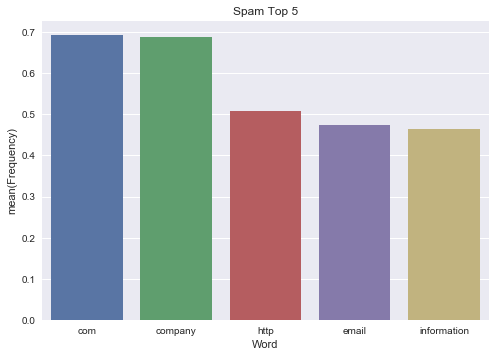

In [18]:
import seaborn as sns

sns.barplot(x='Word',y='Frequency',data=SpamTop30[:5]).set_title('Spam Top 5')

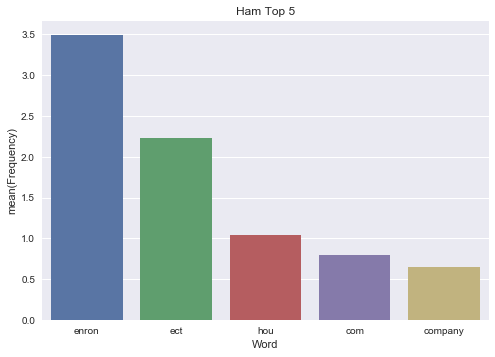

In [19]:
sns.barplot(x='Word',y='Frequency',data=HamTop30[:5]).set_title('Ham Top 5')

#### Reading Boxplots
The boxplots are used to illustarte the spread of email lengths for spam and ham.
Middle line is median, lower box limit in lower quartile, upper boxlimit is upper quartile. Data outside whiskers are outliers. The middle half of a data set falls within the interquartile range. In a boxplot, the interquartile range is represented by the width of the box (Q3 minus Q1).


First the email lengths are appended to the data frame of the training set:

In [20]:
EmailLen = email_train.str.len()
index = EmailLen.index
DFEmailLen = pd.DataFrame({'Length':EmailLen.values, 'Spam':spam_train.values}, index=index)
EmailLen = pd.concat([email_train,DFEmailLen], axis=1)
EmailLen.tail(10)

,Email,Length,Spam
18885,"Subject: hey , no husband at home\nwith my onl...",252,1
30799,Subject: guzzle like a fountain\nspur m rocks ...,973,1
22939,"Subject: and q soft metrics\nhi louise ,\natta...",1059,0
19101,Subject: last notice\noriginal replica rolex a...,632,1
26768,Subject: the original\nyour woman needs an and...,192,1
13374,"Subject: thanks again\nvince and stinson ,\ni ...",936,0
31798,Subject: get the body you want !\nhow are you ...,705,1
2554,Subject: make money giving away free stuff !\n...,1724,1
14463,Subject: here it is\nhey toby\nthere ' s no re...,266,1
7508,Subject: thank god hes gone\ncome and checkout...,512,1


The outliers greatly affect the boxplot representation. The largest email was earlier observed as being around 179000 characters long, and this is clearly illustrated in the ham box plot.


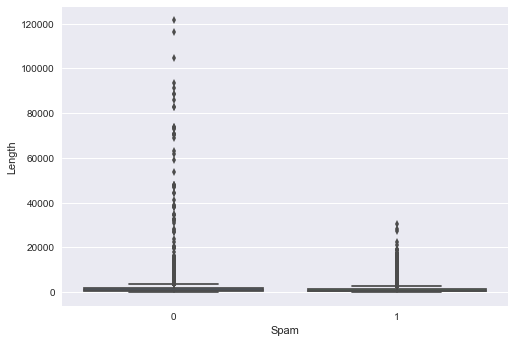

In [21]:
sns.boxplot(x='Spam',y='Length',data=EmailLen)

It is more beneficial to limit the y-axis and take a closer look at the boxplot data. It can be seen that the boxplots match the DataFrame describe() method that was previously called on the training sets. The ham emails have a greater spread in character lengths and a slightly higher median. It has a larger IQ range than the spam data. Both box plots are top heavy, informing us that the data is skewed right.

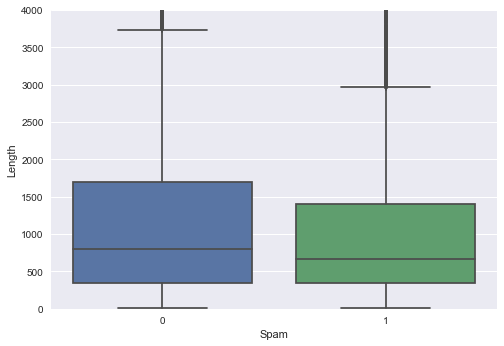

In [22]:
import matplotlib.pyplot as plt
plt.ylim(0, 4000)
sns.boxplot(x='Spam',y='Length',data=EmailLen)

## Supervised Classifier
The next task is to train a supervised classification model on the features and calculate validation accuracy on the hold out validation set. The Naive Batesian classifier is chosen as the supervised classifier, and is described in the following sub-heading.

The accuracy of the classifier is measured, and the classification accuracy and errors of the classifier are investigated. Deeper metrics investigation will be performed in the Model Evaluation section.

The validation set features must be converted to the same TF-IDF BoW representation as the training set, i.e. they must have the same vocabulary.

The validation set features are transformed (not fitted!) using the same CountVEctorizer instance as before, and converted to TFIDF using the TFIDFTransformer.

In [23]:
# dtm/BOW setup for val
email_val_dtm = cv.transform(email_val)

# convert to TFIDF form
email_val_tf = tf.fit_transform(email_val_dtm)
email_val_tf

<6744x53190 sparse matrix of type '<class 'numpy.float64'>'
	with 525849 stored elements in Compressed Sparse Row format>

### Naive Bayes

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The distribution requires integer counts or TF-IDF fractional counts. It is a simple classifier to start with, a probabilistic classifier based on Bayes' theorum with strong and naive assumptions. Despite its simplistic approach, Naive Bayes performs well in complex text-based classification applications, and is known as a competent email classifier [5].

Naive Bayes is less computationally expensive in both CPU and memory compared to other models that might outperform it. Multinomial Naive Bayes is often implemented when the frequency of the words are inportant in the classification problem [6].

 We estimate the conditional probability of a term belongingto a class as the relative frequency of the term in documents belonging to class. [7][5]
 
Naive Bayesian classifiers make assumptions about data, and will generally not perform as well as a more complicated classification model. However, they have several advantages:

- They are extremely fast for training and prediction
- They provide probabilistic prediction
- They have very few possible tunable hyparameters

These advantages make ita good choice as an initial classifier choice. Naive Bayes classifiers perform well in the following circumstances:

- When the naive assumptions match the data
- When model complexity is less important for well seperated data
- For high-dimensional data

The last two points are related: as the dimension of a dataset grows, data becomes more easily seperable. For high dimensionality applications, the more data you have the more powerful a simple Naive Bayesian classifier is [8].

In [24]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# fit tf-idf representation to NB model
nb.fit(email_train_tf, spam_train)

# class predictions for val set
spam_pred = nb.predict(email_val_tf)

### Metrics of Classifier
The sklearn.metrics package provides methods to investigate the nature of the errors that are being made. The metrics of the final best performing classifier are investigated and explained in greater detail in the section "Model Evaluation". The following metrics provide us with a quick evaluation of our Naive Bayesian estimator's performance in this section:

- Classification accuracy
- Distribution
- Null accuracy
- Confusion matrix
- False negatives
- False positives
- Area Under Curve (AUC)




#### Classification Accuracy

In [25]:
from sklearn import metrics

print("Accuracy on training set:")
print(nb.score(email_train_tf, spam_train))

nb_default_acc = metrics.accuracy_score(spam_pred, spam_val)
print("Accuracy on validation set:",nb_default_acc)

Accuracy on training set:
0.991457554725
Accuracy on validation set: 0.985913404508


The classifier performs exceptionally well on the validation set. This is as a result of the use of parameters in our CountVectorizer and using TF-IDF encoding in the feature extraction step of the classifier design.

#### Balance of Distribution

The validation class spam distribution is observed to ensure that the data set is not biased. If the data set was 98% spam, then a classifier that only guessed spam would achieve a 98% success rate.

In [26]:
# examine class distribution
print(spam_val.value_counts())

1    3467
0    3277
Name: Spam, dtype: int64


There is no large majority class, hence the classes are not skewed and distributed evenly in the validation set.

#### Null Accuracy

The null value quantifies how a dumb model that always predicts ham would be right X% of the time. This shows how classification accuracy is not that good as it's close to a dumb model. An ideal null value lies around 0.5. The null accuracy can be applied to multiple class problems, however for this we compute the null accuracy on a classifier that predicts only spam [9].


null_accuracy = count(class 1)/count(total)

In [27]:
# calculate null accuracy
null_accuracy = spam_val.value_counts().head(1) / len(spam_val)
print('Null accuracy:', null_accuracy)

Null accuracy: 1    0.514087
Name: Spam, dtype: float64


#### Confusion Matrix
The confusion matrix can be used to analyze the classes which are most error prone. The error count is found on the off-diagonals.

- True negative: Predicted false, actual false
- False positive: predicted true, actual false
- False negative: predicted false, actual true (spam classified as ham)
- True positive: predicted true, actual true (ham classified as spam)

    [TN FP

    FN TP]
    
In an email classifier both these errors can lead to frustration and miscommunication, so it is vital to investigate why they might have occurred.

In [28]:
# print the confusion matrix
cm = metrics.confusion_matrix(spam_val, spam_pred)
print(cm)

[[3220   57]
 [  38 3429]]


The errors are imbalanced between FN and FP, with tens more FP occuring compared to FN. 



In [29]:
FP1 = email_val[spam_pred > spam_val]
FN1 = email_val[spam_pred < spam_val]

##### False Positives

In [30]:
#print(FP1)
print(FP1[15214])
print("\n")
print(FP1[28169])

Subject: best picks
hey ,
best picks are zigo and smtx
steve


Subject: registration welcome email
thank you for registering at citibank account online . you now have
free access , and hours a day , to your citibank account information .
sign - on at https : / / www . accountonline . com / cb / login . dcl to view your
statements , monitor your unbilled activity and enroll in one of our
electronic payment options . while you ' re there , check out these
great features :
all - electronic - enroll today and make your paper statement a
thing of the past . view it online instead . then , pay your bill
online with click - to - pay or autopay .
express request - manage your citibank account information from
your computer . change your address , request a credit line
increase , order a replacement card and more .
citibank bill manager - receive and pay all of your bills online .
secure messaging - have a question ? use our secure message pad to
correspond safely with our customer care center 

The first email chosen for further inspection is very short in length. It does not refer to any of the key ham words such as "Enron" or describe business matters. 

The email has the hallmarks of spam, as it uses the superlative "best" which is a spam Top 30 frequenct word.

The second email is much longer, a registration welcome email for an online bank account. The email advertises its online account using highly frequent spam words such as "free", "click" and "account". It is easy to see why this email was mistakenly labelled as spam, this may happen with many ham emails which advertise products in such a manner.

These spam words are recurring themes throughout the false positive emails, and is quite difficult to improve the accuracy for the majority of these instances. Labelling using IP reputations or a better defined spam word collection may improve the frequency of these errors.
 

##### False Negatives

In [31]:
#print(FN1)

print(FN1[8382])
print("\n")
print(FN1[33131])

Subject: the hotel show
last chance to exhibit at
the hotel show and
and - and may , and , airport expo dubai , uae
with over and luxury hotels and resorts planned in the middle east within the next and - and years , ' the hotel show ' has established itself as the region ' s premier hospitality event for local & international companies wishing to meet directly with major players in the industry .
strong industry support
' the hotel show ' is owned by the uk ' s daily mail group , one of the world ' s largest media conglomerates with and exhibitions worldwide , including index and big and in dubai .
held annually at the airport expo dubai , ' the hotel show ' receives full industry support from regional hospitality - related official bodies and associations such as the dubai department of tourism & commerce marketing and the kuwait hotel owner ' s association , aswell as governmental organisations such as the department of trade & industry in the u . k who ranked the event as one of th

The first email is spam, as it is directed to nobody in particular offering advertising "The Hotel Show". It uses terms from industry which are assosciated with the business (e.g. "marketing", "industry", "managed" and "assosciation"). Signed off "yours sincerely", it has an official feel to it, and it is clear to see how the words it uses may not have been detected by the spam filter.

The second spamemail investigated is shorter, and also lacks spam words. Notice how spelling mistakes "aredit cpproved... cecks" are not detected by the spam filter. This may have been an intentional ploy by the spammers. 

These are assumptions as to why the above emails are spam, but the classifier identifies them using their word characteristics, and it can be seen why it mistakes the class of both emails. This is a recurring theme throughout the flase negative emails.


#### Predict Probability
Naive Bayes predicts extreme probabilites, and should be taken at face value. However, it is a useful guide to show which emails correlate strongly to spam. 


In [32]:
# right column: probability of spam
y_probSpam = nb.predict_proba(email_val_tf)[:, 1]
y_probSpam

array([  1.60915463e-01,   2.38176235e-03,   2.27037169e-04, ...,
         3.48148271e-02,   9.98340505e-01,   9.70397606e-01])

#### AUC
Area under curve (AUC) provides a useful number to quantify the classifier performance. AUC represents performance 
averaged over all possible cost ratio. The higher the AUC value (max of 1.0) the better the classifier performance. AUC represents the the probability that if a positive and negative class are randomly selected, the classifier will assign a higher predicted probability to a positive observation [richtienglink].



In [33]:
# calculate AUC
metrics.roc_auc_score(spam_val, y_probSpam)

0.99809274577099438

### Saving Model using Pickle
The Pickle module implements a powerful algorithm for serializing and de-serializing Python object structures. "Pickling" converts the object into a byte stream, and "unpickling" is the inverse operation [10] [11].



In [34]:
import pickle
NBfilename = 'naive_bayesian_count_vectorize_2311.pkl'
# save as pkl file
NBpkl = open(NBfilename, 'wb')
# dump object to pkl file
pickle.dump(nb, NBpkl)
# Close the pickle instance
NBpkl.close()

## Model Selection

There are several candidate models that can theoretically perform effective binary supervised classification for a text based model to different degrees of accuracy:
- Logistic Regression
- Stochastic Gradient Descent
- Support Vector Machine (Linear Support Vector Classifier)
- Random Forest Classifier

Cross validation is used to tune the hyperparameters and retain the most accuarate model.


In [35]:
## Tuned NB
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': np.logspace(-2, 2, 100) }
clf = GridSearchCV(MultinomialNB(), param_grid)
clf.fit(email_train_tf, spam_train)
best_alpha = clf.best_estimator_.alpha
print(" Best score: ", clf.best_score_ )
print("alpha hyperparameter for best score: ", best_alpha)

clf = MultinomialNB(alpha = best_alpha)
clf.fit(email_train_tf, spam_train)
spam_pred = clf.predict(email_val_tf)
nb_tuned_acc = metrics.accuracy_score(spam_val, spam_pred)
print("Tuned NB score: ",nb_tuned_acc)

#pickle dump
NBTfilename = 'NB_tuned_2911.pkl'
NBTpkl = open(NBTfilename, 'wb')
pickle.dump(clf, NBTpkl)
# Close the pickle instances
NBTpkl.close()


 Best score:  0.98908465326
alpha hyperparameter for best score:  0.0642807311728
Tuned NB score:  0.988730723606


### Logistic Regression

Logistic regression is a classification algorithm despite its name containing the word "regression". 

The Logistic Regression algorithm [12]:
1. Initializes the weight vector to zero.
2. Trains the features while minimizing the logistic loss. This can be done by implementing grdient descent.
3. Calculate the logistic loss on the test set.

The sigmoid or activation function takes any number and converts it to a number between 0 and 1. Logical targets are predicted fitted to the relationship.

Similarly to linear regression, in logistic regression we want to minimize the loss function, by finding its critical point, i.e. where the gradient is zero. Gradient descent takes a random guess for gradient parameters and iteratively improves its guess.

Hyperparamteters include:
- Number of max iterations
- L2 regularization parameter (C)
- Solvers













The default Logisitc Regression paramters using sklearn.linear_model LogisitcRegression model. 

In [36]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression() # C=1.0, no class weight, L2 penalty
clf.fit(email_train_tf, spam_train)
spam_pred = clf.predict(email_val_tf)

# calculate accuracy
lrg_default_acc = metrics.accuracy_score(spam_val, spam_pred)
print("Linear regression default accuracy: ", lrg_default_acc)

# pickle
LRfilename = 'logisitc_regression_default_2511.pkl'
LRDpkl = open(LRfilename, 'wb')
pickle.dump(clf, LRDpkl)
LRDpkl.close()

Linear regression default accuracy:  0.982651245552


Not quite as acuracte as tuned NB model, but has better AUC. With more tuning of hyper-parameters and regularization it may outperform NB model.

#### Regularization
Regularization adds information to prevent overfitting and minimize structural risk. The additional information is usually a penalty included in the loss function.

** L2 Regularization **
Adds penalty to loss function for large weights. Penalty is L2 normalization of the weights. L2 regularizatio is known as weight decay, slowly decaying weights towards zero each iteration. L2 encourages solutions with smaller weights, as large weights lead to large changes in output if the input changes.

The regularization parameter λ controls the tradeoff between small weights and fitting the data. Smaller values for λ place an emphasis on fitting the data, and is suitable for low-noise models with few parameters to fit. Large values of λ are suitable when there is lots of noise or many parameters to fit. 

In Scikit-learn, the C parameter is the inverse of λ.

** L1 Regularization **
encourages sparse solutions, where the most of the weights tend to be zero. L1 chooses a subset of features, and sets the weights of those not selected to zero. For the purpose of Bag of Words and email classification, this more extreme regularization approach for larger data sets to reduce overfitting may not be necessary.

##### K-fold cross validation

To find the hyper-parameters that provide the best Logistic Regression using L" regularization, k-fold cross validation is employed. Its steps are:
- Divide training set into k equal validation sets
- Train all sets as models and choose the best performing model and its hyperparameters
- Evaluate the model on the test set

The sklearn.cross_validation GridSearchCV implements 3-fold cross validation by default. Due to the large data set, lerger K-fold cross-validation is simply too computationally costly. Each hyper-parameter is tuned using GridSearchCV seperately, as this is computationally more efficient [13].

In [37]:
# Tune C parameter
param_grid = {'C': np.linspace(0.001, 10, 100) }
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
clf.fit(email_train_tf, spam_train)
best_C = clf.best_estimator_.C
print(" Best score: ", clf.best_score_ )
print("C hyperparameter for best score: ", best_C)

# Tune solver
param_grid = {'solver': [ 'newton-cg', 'lbfgs', 'liblinear'] }
clf = GridSearchCV(LogisticRegression(penalty='l2',C=best_C), param_grid)
clf.fit(email_train_tf, spam_train)
spam_pred = clf.predict(email_val_tf)
metrics.accuracy_score(spam_val, spam_pred)
best_solver = clf.best_estimator_.solver
print(" Best score: ", clf.best_score_ )
print("Solver hyperparameter for best solver: ", best_solver)

# Tune max_iter
param_grid = {'max_iter': [100,1000,10000,100000] }
clf = GridSearchCV(LogisticRegression(penalty='l2',C=best_C, solver=best_solver), param_grid)
clf.fit(email_train_tf, spam_train)
spam_pred = clf.predict(email_val_tf)
metrics.accuracy_score(spam_val, spam_pred)
best_iter = clf.best_estimator_.max_iter    # max_iter required is 100, the default
print("Solver hyperparameter for best max_iter: ", best_iter)

 Best score:  0.987660912381
C hyperparameter for best score:  8.384


The tuned parameters are used in the final optimized Logistic Regression model design.

In [40]:
# Final tuned LG model
clf = LogisticRegression(penalty='l2',C=best_C, solver=best_solver,max_iter=best_iter)
clf.fit(email_train_tf, spam_train)
spam_pred = clf.predict(email_val_tf)
lrg_tuned_acc = metrics.accuracy_score(spam_val, spam_pred)
print("Tuned LR accuracy score: ",lrg_tuned_acc)

# save tuned model
LRTunedfilename = 'logisitc_regression_tuned_2511.pkl'
LRTpkl = open(LRTunedfilename, 'wb')
pickle.dump(clf, LRTpkl)
LRTpkl.close()

Tuned LR accuracy score:  0.987692763938


### SGD Model

Stochastic Gradient Descent (SGD) is a simple and effective approach to linear regression classifiers, and can be applied to logistical regression loss functions. The main idea is that instead of computing the gradient of the loss for the full dataset, estimate it using a randomly chosen example and move in that direction. It has been successfully applied to text classification and natural language processing. Given that the data is sparse, it can scale to handle problems with over 10^5 features relatively easily [14].

The advantages of using SGD:
- Efficiency and sparse data
- Ease of implementation

The disadvantages include:
- SGD requires the tuning of many parameters:
    - Regularization parameter
    - Number of iterations
    - Learning rate
    - alpha constant that multiplies regularization term
- Sensitive to feature scaling






In [41]:
# untuned SGD Cllassifier
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss="log", penalty="l2")
sgd.fit(email_train_tf, spam_train)
spam_pred = sgd.predict(email_val_tf)
sgd_default_acc = metrics.accuracy_score(spam_val, spam_pred)
print("Default SGD Accuracy score: ",sgd_default_acc)

Accuracy score:  0.980278766311


Hyperparamterer tuning:

In [42]:
# tune learning_rate
param_grid = {'learning_rate': ['constant','optimal','invscaling'] }
sgd = GridSearchCV(SGDClassifier(loss="log", penalty="l2",eta0=0.0000000000000001), param_grid)
sgd.fit(email_train_tf, spam_train)
spam_pred = sgd.predict(email_val_tf)
best_lr = sgd.best_estimator_.learning_rate
print(" Best score: ", sgd.best_score_ )
print("Solver hyperparameter for best max_iter: ", best_lr)

# tune eta0
param_grid = {'eta0': np.linspace(0.0,1, 100) }
sgd = GridSearchCV(SGDClassifier(loss="log", penalty="l2",learning_rate=best_lr), param_grid)
sgd.fit(email_train_tf, spam_train)
spam_pred = sgd.predict(email_val_tf)
best_eta0 = sgd.best_estimator_.eta0
print("Solver hyperparameter for eta0: ", best_eta0)

# tune regularization
param_grid = {'penalty': [ 'none', 'l2', 'l1', 'elasticnet'] }
sgd = GridSearchCV(SGDClassifier(loss="log",learning_rate=best_lr,eta0=best_eta0), param_grid)
sgd.fit(email_train_tf, spam_train)
spam_pred = sgd.predict(email_val_tf)
best_penalty = sgd.best_estimator_.penalty
print("Solver hyperparameter for best penalty: ", best_penalty)

# tune alpha
param_grid = {'alpha': np.logspace(-15,-3, 100) }
sgd = GridSearchCV(SGDClassifier(loss="log",penalty=best_penalty,learning_rate=best_lr,eta0=best_eta0), param_grid)
sgd.fit(email_train_tf, spam_train)
spam_pred = sgd.predict(email_val_tf)
best_alpha = sgd.best_estimator_.alpha
print("Solver hyperparameter for best alpha: ", best_alpha)

 Best score:  0.983330367207
Solver hyperparameter for best max_iter:  optimal


Combination of tuned hyperparamteters:

In [46]:
# Tuned SGD
sgd = SGDClassifier(loss="log", penalty=best_penalty,eta0=best_eta0,learning_rate=best_lr, alpha=best_alpha)
sgd.fit(email_train_tf, spam_train)
spam_pred = sgd.predict(email_val_tf)
sgd_tuned_acc = metrics.accuracy_score(spam_val, spam_pred)
print( "Accuracy score: ", sgd_tuned_acc)

# pickle
SGDTfilename = 'SGD_tuned_2711.pkl'
SGDTpkl = open(SGDTfilename, 'wb')
pickle.dump(clf, SGDTpkl)
SGDTpkl.close()

Accuracy score:  0.988285883749


### SVM

Support Vector Machines (SVMs) are a set of supervised learning algorithms for classification, regression and outlier detection [15]. 

SVM advantages include:
- Effective for large amounts of features
- Memory efficient
- Easy to tune hyperparameters and specify custom kernels

Disadvantages:
- Potential to overfit when large number of features and tuning hyperparameters
- Do not provide probability estimates
- Use expensive K-fold cross validation

SGD can be used to solve soft-margin SVM problems. Adavtageous since:
- Not necessary to store full dataset in memory when training.
- Can be faster than solving the quadratic problem.

Soft margin SVM is available in sklearn.svm as the LinearSVC (Support Vector Classification) object. It implements a linear kernel with more flexibility in the choice of penalties and loss function and scales well for large data sets, perfect for the Enron data set [16].



##### Hyperparameters

C is a regularization hyperparameter in soft-margin SVM:
- Large C:  high penalty for violation constraints, narrower margin.
- Small C:  low penalty for violating constraints, larger margin.
- C → ∞: produces hard-margin SVM.







In [47]:
from sklearn import svm

# tune C
param_grid = {'C': np.logspace(-1,1, 100) }
svc = GridSearchCV(svm.LinearSVC(), param_grid)
svc.fit(email_train_tf, spam_train)
spam_pred = svc.predict(email_val_tf)
best_C = svc.best_estimator_.C
print("Best score: ", svc.best_score_ )
print("Solver hyperparameter for best C: ", best_C)

Accuracy on validation set 0.988879003559
Prediction accuracy score 0.988879003559
Accuracy on validation set 0.986358244365
Prediction accuracy score 0.986358244365
Accuracy on validation set 0.984134045077
Prediction accuracy score 0.984134045077


In [49]:
#tuned model
clf = svm.LinearSVC(C=best_C)
clf.fit(email_train_tf, spam_train)
spam_pred = clf.predict(email_val_tf)
svm_tuned_acc = metrics.accuracy_score(spam_val, spam_pred)
print("Prediction accuracy score", svm_tuned_acc)

# save tuned model
LSVCfilename = 'LSVC_tuned_2711.pkl'
LSVCpkl = open(LSVCfilename, 'wb')
pickle.dump(clf, LSVCpkl)
LSVCpkl.close()

Prediction accuracy score 0.989027283511


### Comparison of linear SVM and logistic regression

Linear SVM uses the hinge loss:
- No penalty for examples on correct side of margin
- Linear penalty for examples that violate margin
- Robust to outliers
- Must use L2 to maximize margin

Logistic regression uses logistic loss:
- Penalty for correct examples
- Less robust than hinge to outliers
- Can use L2, advisable in this application but not necessary



### Random Forest Classifier

A random forest classifier fits a number of decision trees to the subdivided training set. It imprroves variance minimization by reducing the correlation between base tree models.
 
 
Hyperparameters include:
- Number of trees
- Depth of trees
- Number of random features at each split


In [53]:
## GridsearchCV takes long tme to tune hyper-parameters!!!
## Results of tuing are defined below
from sklearn.ensemble import RandomForestClassifier

#rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

#param_grid = { 
#    'n_estimators': [20, 50],
#    'max_features': ['log2', 'sqrt'],
#    'min_samples_leaf': [1,2,3] 
#}

#CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
#CV_rfc.fit(email_train_tf, spam_train)
#print(CV_rfc.best_params_)

In [54]:
# Default RFC
rfc = RandomForestClassifier()
rfc.fit(email_train_tf, spam_train)
spam_pred = rfc.predict(email_val_tf)
rfc_acc = metrics.accuracy_score(spam_val, spam_pred)
print("Prediction accuracy score", rfc_acc)

# Hyperparameters using GridsearchCV
num_trees = 50
max_ft = 'log2'
leaf = 1
depth = None

# Tuned RFC
rfc = RandomForestClassifier(n_jobs=-1,max_features= max_ft ,n_estimators=num_trees, max_depth = depth
                             ,min_samples_leaf =leaf)
rfc.fit(email_train_tf, spam_train)
spam_pred = rfc.predict(email_val_tf)
rfc_tuned_acc = metrics.accuracy_score(spam_val, spam_pred)
print("Prediction accuracy score", rfc_tuned_acc)

Prediction accuracy score 0.970492289442
Prediction accuracy score 0.982947805457


Not as accurate as other models even after tuning. Requires laarge amounts of tuning but does not scale well, slow for tuning using GridSearchCV for large number of features.

### Comparing Model Accuracies


In [80]:
model_accs = {  'NB': nb_default_acc, 'NB Tuned':nb_tuned_acc,
                'LR': lrg_default_acc, 'LR Tuned': lrg_tuned_acc,
                'SVC': svm_default_acc, 'SVC Tuned': svm_tuned_acc,
                'RFC': rfc_acc, 'RFC Tuned': rfc_tuned_acc
             }

print(model_accs)
max_model = max(model_accs, key=model_accs.get)

{'NB': 0.98591340450771059, 'NB Tuned': 0.98873072360616843, 'LR': 0.98265124555160144, 'LR Tuned': 0.98769276393831551, 'SVC': 0.98887900355871883, 'SVC Tuned': 0.98902728351126923, 'RFC': 0.97049228944246735, 'RFC Tuned': 0.98294780545670224}


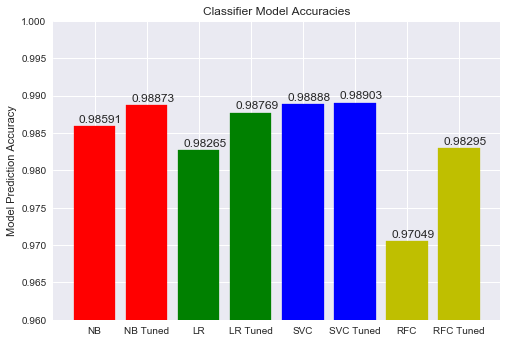

In [57]:
import matplotlib.pyplot as plt

plt.bar(range(len(model_accs)), model_accs.values(), align='center')

plt.xticks(range(len(model_accs)), model_accs.keys())

# https://stackoverflow.com/questions/1221108/barchart-with-vertical-labels-in-python-matplotlib
for a,b in zip(range(len(model_accs)), model_accs.values()):
    plt.text(a-.3, b +.0005,str(round(b, 5)))
    
#plt.tight_layout()
plt.ylim([0.96,1.0])
bl = plt.bar(range(len(model_accs)), model_accs.values(), align='center');
bl[0].set_color('r')
bl[1].set_color('r')
bl[2].set_color('g')
bl[3].set_color('g')
bl[4].set_color('b')
bl[5].set_color('b')
bl[6].set_color('y')
bl[7].set_color('y')

plt.title('Classifier Model Accuracies')
plt.ylabel('Model Prediction Accuracy')

In [92]:
print("Best Model: ",max_model, model_accs[max_model])

Best Model:  SVC Tuned 0.989027283511


The Linear SVC performs the best at spam classification for the large Enron data set. Note that priorto tuning of hyperparameters, it outperformed the other supervised classifier models. Logistic Regression requires tuning of large amounts of hyperparameters,and does not drastically improve on the other models. Naive Bayes classifier is simplistic yet more accurate than the Logistic Regression model.

The tuned Linear SVC is chosen as the superior supervised classification model, and is evaluated in the following section.

## Model Evaluation



The sklearn.metrics package provides methods to investigate the nature of the errors that are being made. The metrics which are of interest to us in this report are:
- classification accuracy
- the null accuracy
- the confusion matrix
- flase positives and true negatives
- precision
- recall
- precision-recall curve
- F1 scores
- average precision
- true positive rate
- false positive rate
- receiver operator characteristic (ROC curve)
- area under curve (AUC)


### Load Module & Test Set

The desired Pickle saved model can be loaded from the hard disk for evaluation. The test emails are retrieved and converted to tf-idf format. 

In [59]:
# Loading the saved pkl model
mod = open(LSVCfilename, 'rb')
clf = pickle.load(mod)
print("Loaded model :: ", clf)

Loaded model ::  LinearSVC(C=1.3530477745798075, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)


In [60]:
# dtm/BOW setup for val
email_test_dtm = cv.transform(email_test)
# convert to TFIDF form
email_test_tf = tf.fit_transform(email_test_dtm)
email_test_tf

<10115x53190 sparse matrix of type '<class 'numpy.float64'>'
	with 772187 stored elements in Compressed Sparse Row format>

### Accuracy on Test Set

It was all well and good choosing a classifier model that performed well on the validation set, but now it is time to see how it performs when predicting the classes of the larger and previously unseen test set. Ideally, there should be as little change as possible between the accuracy on the validation set and the test set.

In [61]:
spam_pred = clf.predict(email_test_tf)
svm_tuned_test_acc = metrics.accuracy_score(spam_test, spam_pred)
print("Prediction accuracy score on test set: ", svm_tuned_test_acc)
#compare to validation set
print("Prediction accuracy score on validation set: ", svm_tuned_acc)

Prediction accuracy score on test set:  0.989718240237
Prediction accuracy score on validation set:  0.989027283511


The classifier performs to a similar level on the test set as it did on the validation set, confirming the decision to selectit as the preferred model. In fact, it performs slightly better on the larger test set. 

With an accuracy close to 99%, the tuned Linear SVC is clearly the preferred model from those that were tested in the previous section.

### Metrics

The sklearn.metrics package benchmarks the performance of a classifier in several ways. The documentation for these metrics is available at: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.

The sklearn classifier metrics investigated for the model evaluation include:

- classification report
- OOS/zero-one error
- confusion matrix
- FPR and TPR
- precision recall curve and scores
- Average precision
- F1 score
- Balanced accuracy
- ROC curve
- AUC score
- Null value

Some of these metrics have already been described in the section investigating the first supervised classifier design.

#### OOS Error

Out of sample error. This is the error of classifier accuracy when predicting on an unseen test set after training. Also known as zero-one error

In [62]:
oos = 1 - svm_tuned_test_acc
print("OOS Error: ", oos)

OOS Error:  0.0102817597627


#### Classification Report

An sklearn.metrics function that returns an overview report of class precision, recall, F1 scores and sample sizes.

In [63]:
print(metrics.classification_report(spam_test, spam_pred))

             precision    recall  f1-score   support

          0       0.99      0.98      0.99      4931
          1       0.99      0.99      0.99      5184

avg / total       0.99      0.99      0.99     10115



#### Null Accuracy

The skewness ofthe test set. If estimator predicted spam every time on a test set containingmostly spam, it would have a high accuracy but not be a high quality estimator.

In [64]:
# calculate null accuracy
null_accuracy = spam_test.value_counts().head(1) / len(spam_test)
print('Null accuracy:', null_accuracy)

Null accuracy: 1    0.512506
Name: Spam, dtype: float64


#### Confusion Matrix
The confusion matrix can be used to analyze the classes which are most error prone. The error count is found on the off-diagonals.

- True negative: Predicted false, actual false
- False positive: predicted true, actual false
- False negative: predicted false, actual true (spam classified as ham)
- True positive: predicted true, actual true (ham classified as spam)

    [TN FP

    FN TP]
    
In an email classifier both these errors can lead to frustration and miscommunication, so it is vital to investigate why they might have occurred.

In [65]:
cm = metrics.confusion_matrix(spam_test, spam_pred)
print(cm)
TP = cm[0,0]
TN = cm[1,1]
FP = cm[1,0]
FN = cm[0,1]

FP_mail = email_test[spam_pred > spam_test]
# messages for FN (spam incorrectly classified as ham)
FN_mail = email_test[spam_pred < spam_test]

[[4853   78]
 [  26 5158]]


In [66]:
print(FP_mail[14733])
print("\n")
print(FP_mail[29933])

Subject: career goals - david porter
greetings bill ,
here is a copy of my career goals .
david .
- career goals . doc


Subject: it ' s not the same without your smiling face ! ! ! ! ! !
i hope all is well for you and your family . . . . how is that precious daughter
of yours ? i bet meghan is really growing ! ! ( sorry , i probably mispelled
her name )
we miss you very much but so glad you found a new " home " . . . . . ( ie work place )
i wanted to drop a line and say hello . . . . .
i ' m enjoying working at campus . it ' s very nice being close to home and my
son ' s school .
take care ,
sharee


The false positives account for 75% of the misclassified emails. The Linear SVC has reduced the number of false negatives compared to the first Naive Bayesian model we previously evaluated. The recurring theme from the false positives is that they are usually short personal emails which are not clearly company related. The spam detector performs more like a "work-related mail" detector. This is difficult to avoid given the Enron dataset, as most ham mail are company mail.

Perhaps the Enron dataset is not ideal for training a spam classifier, as its ham emails are too work related.

In [67]:
print(FN_mail[30703])

Subject: re : saturday . here new and
good day :
i tried to call your and three time but your phone is not available . i think
you did a mistake during filling the form . anyway , your mortgagge request
# and was appproved with and . and , please reenter your info here
and we will start asap
thank you
lavern horton
ljmej



The false negative rate has improved. The small amount of spam that is not being detected avoids spam-assosciated words. Spam detection could incorporate the greetings in emails, as spam emails usually do not address a specific recipient.

** Confusion Matrix Implications For Production Classifier**

The confusion matrix has implications for the application of this model. The small amount of false negatives do not pose an issue to the users, as an odd spam email every few weeks is unlikely to cause any issues. Users shouldbe able to mark emails as spam vocabulary, and this would help reduce the false negative rate further.

However, the false positive rate is more troublesome. The result of an important email being misclassified as spam may be severe depending on the importance of the email. In most false positive cases the emails are personal chat or order confirmations that can be easily mistaken for spam. The false positive rate could be reduced by incorporating trusted IP features in the classifier or training on a more specific set of spam features.

#### Balanced Accuracy
It is beneficial to use balanced accuracy when there is an imbalance in class sizes. It computes the same accurcay as if the test set was balanced.

In [68]:
bal_acc = 0.5*(TP/(TP+FP) + TN/(FN+TN))
print("Balanced accuracy is: ",bal_acc )

Balanced accuracy is:  0.989887085655


#### FPR & TPR

True positive rate:

- How often your email system will detect spam when spam emaail is present


False positive rate:
- How often your email system will detect spam when ham email is present

In [69]:
# False positive rate and true positive rate
FPR = FP/(FP+TN)
TPR = TP/(TP+FN) #same as recall
print("FPR: ", FPR)
print("TPR: ", TPR)

FPR:  0.00501543209877
TPR:  0.984181707564


#### Precision Recall Curve

- **Precision**: Proportiion of returned results are relevant, positive prediction

- **Recal**: Proportion of all relevant results that are returned, sensitivity

Precision = TP/P

Recall = TP/T


It is easy to get 100% precision or 100% recall, but there is often a trade-off between the two. Thresholdingthe classifier score at different vales gives different precision and recall values. This can be observed using a precision recall curve.


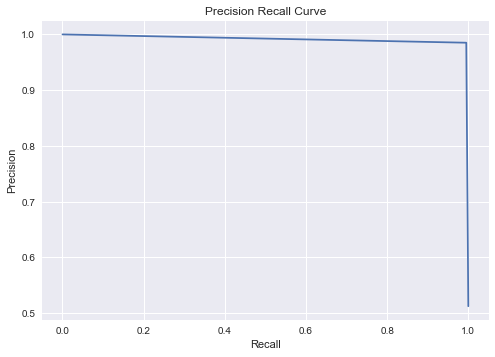

In [70]:
precision, recall, thresholds = metrics.precision_recall_curve(spam_test, spam_pred)
plot(recall,precision)
xlabel('Recall')
ylabel('Precision')
title('Precision Recall Curve')

#### F1 Score
F1 scores are metrics that combine precision and recall. The F1 score is the harmonic mean of precision and recall:

F1 = 2(Precision x Recall)/(Precision + Recall)

An F1 score reaches its optimum score at 1. The contribution of precision and recall to the F1 function are equal.

In [71]:
print("F1 Score: ",metrics.f1_score(spam_test, spam_pred))

F1 Score:  0.990019193858


#### Average Precision

Integrating the precision function over all possible thresholds gives the average precision, or area under the precision curve.


In [72]:
average_precision = metrics.average_precision_score(spam_test, spam_pred)
print("Average precision score is: ",average_precision)

Average precision score is:  0.991329070002


#### ROC Curve & AUC

The receiver operator characteristic is a graph of TPR vs FPR as the threshold is varied.

- TPR vs FPR
- Sensitivity vs 1-Specificity

The area under the curve (AUC) is calculated using the trapezoidal rule. The sklearn metrics package provides a function to do this for us. AUC represents the classifier's performance averaged over all possible cost ratios.




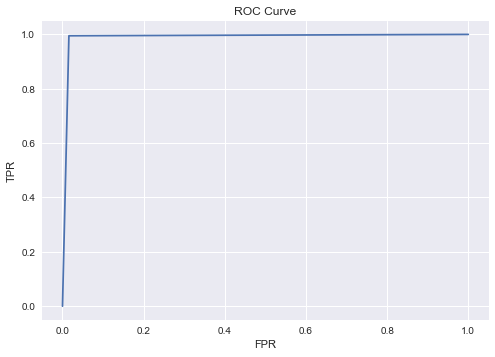

In [73]:
fpr, tpr, thresholds = metrics.roc_curve(spam_test, spam_pred)
plot(fpr,tpr)
xlabel('FPR')
ylabel('TPR')
title('ROC Curve')

In [74]:
auc = metrics.auc(fpr, tpr)
print("AUC is: ", auc)

AUC is:  0.989583137733


## Final Pipeline

The model can be combined in a pipeline rather than in several seteps, reducing the complexity of the cross-validation process. The pipeline can combine feature extractors, classifier models and memory.


In [104]:
from sklearn.pipeline import Pipeline

# Loading the saved pkl model
mod = open(LSVCfilename, 'rb')
clfin = pickle.load(mod)
print("Loaded model :: ", clfin)

text_clf = Pipeline([('vect', CountVectorizer(analyzer='word',stop_words=stop_words, min_df = 2, max_df = 1.0)),
                      ('tfidf', TfidfTransformer()),
                      ('clf', clfin)
                    ])

text_clf.fit(email_train, spam_train)

spam_pred = text_clf.predict(email_test)
accy = metrics.accuracy_score(spam_test, spam_pred)
print("Prediction accuracy score on test set: ", accy)


Loaded model ::  LinearSVC(C=1.3530477745798075, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)
Prediction accuracy score on test set:  0.989915966387


## Conclusion

The training set is encoded as a Bag of Words representation, and transformed to TF-IDF format. Several classifiers are trained on the training set. Tuning and model selection takes place on the validation set, proir to final model evaluation on the unseen test set.

The tuned Linear SVC classification performs best with the given spam detection application and data sets. All three supervised classifiers perform to a high degree of accuracy (98% to 99%). A main contributing factor to this high accuracy is the feature extraction and pre-processing decisions, such as the use of stop-word removal, ignoring numbers and using TF-IDF encoding.

The model could be improved using a larger data set, better ham or spam examples, stemming, more complicated and computationally expensive algorithms, or by performing more exhaustive hyperparameter tuning on more cross-validation iterations. A dedicate GPU could be appropriate to perform  the extensive cross-validation timing required to tune moore complex modelsto a higher degree of accuracy. This project combines an effective solution that is relatively computationally cheap to design.

## References

[1] Python For Engineers. (2017). Build a Spam Filter. [online] Available at: http://pythonforengineers.com/build-a-spam-filter/ [Accessed 30 Nov. 2017].

[2] Python-notes.curiousefficiency.org. (2017). Processing Text Files in Python 3 — Nick Coghlan's Python Notes 1.0 documentation. [online] Available at: http://python-notes.curiousefficiency.org/en/latest/python3/text_file_processing.html [Accessed 30 Nov. 2017].

[3] Datasciencecentral.com. (2017). Python Scikit-learn to simplify Machine learning : { Bag of words } To [ TF-IDF ]. [online] Available at: https://www.datasciencecentral.com/profiles/blogs/python-scikit-learn-to-simplify-machine-learning-bag-of-words-to [Accessed 30 Nov. 2017].

[4] Scikit-learn.org. (2017). sklearn.feature_extraction.text.TfidfTransformer — scikit-learn 0.19.1 documentation. [online] Available at: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer.fit_transform [Accessed 30 Nov. 2017].

[5] Vryniotis, V. and Vryniotis, V. (2017). Machine Learning Tutorial: The Naive Bayes Text Classifier | Datumbox. [online] Blog.datumbox.com. Available at: http://blog.datumbox.com/machine-learning-tutorial-the-naive-bayes-text-classifier/ [Accessed 30 Nov. 2017].

[6] Scikit-learn.org. (2017). 1.9. Naive Bayes — scikit-learn 0.19.1 documentation. [online] Available at: http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes [Accessed 30 Nov. 2017].

[7] Nlp.stanford.edu. (2017). Naive Bayes text classification. [online] Available at: https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html [Accessed 30 Nov. 2017].

[8] VanderPlas, J. (2017). In Depth: Naive Bayes Classification | Python Data Science Handbook. [online] Jakevdp.github.io. Available at: https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html [Accessed 30 Nov. 2017].

[9] ritchieng.github.io. (2017). Vectorization, Multinomial Naive Bayes Classifier and Evaluation. [online] Available at: http://www.ritchieng.com/machine-learning-multinomial-naive-bayes-vectorization/ [Accessed 30 Nov. 2017].

[10] Docs.python.org. (2017). 11.1. pickle — Python object serialization — Python 2.7.14 documentation. [online] Available at: https://docs.python.org/2/library/pickle.html [Accessed 30 Nov. 2017]. 

[11] Dataaspirant. (2017). How to save Scikit Learn models with Python Pickle library. [online] Available at: http://dataaspirant.com/2017/02/13/save-scikit-learn-models-with-python-pickle/ [Accessed 30 Nov. 2017].

[12] Classes.soe.ucsc.edu. (2017). Cite a Website - Cite This For Me. [online] Available at: https://classes.soe.ucsc.edu/cmps242/Winter08/hw/hw3/hw3reports/Nikhila_report.pdf [Accessed 30 Nov. 2017]. 

[13] Scikit-learn.org. (2017). Model selection: choosing estimators and their parameters — scikit-learn 0.19.1 documentation. [online] Available at: http://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html [Accessed 30 Nov. 2017].

[14] Scikit-learn.org. (2017). 1.5. Stochastic Gradient Descent — scikit-learn 0.19.1 documentation. [online] Available at: http://scikit-learn.org/stable/modules/sgd.html [Accessed 30 Nov. 2017].

[15] Scikit-learn.org. (2017). 1.4. Support Vector Machines — scikit-learn 0.19.1 documentation. [online] Available at: http://scikit-learn.org/stable/modules/svm.html [Accessed 30 Nov. 2017].

[16] Scikit-learn.org. (2017). sklearn.svm.LinearSVC — scikit-learn 0.19.1 documentation. [online] Available at: http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC [Accessed 30 Nov. 2017].

